# Model mismatched entity prediction analysis
In this notebook, we'll dig deeper into why the SciERC model was able to outperform all other models on PICKLE.

The script `evaluate_model_output.py` contains an option, `--save_mismatches`, which is used to generate the output used in this notebook. Evaluation is performed without consoideration of types, but types are included in the output to facilitate downstream analysis of model performance based on type categories.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import jsonlines
from ast import literal_eval
from collections import defaultdict, Counter
from functools import reduce

## Reading in the mismatches

In [112]:
all_models = pd.read_csv('../data/straying_off_topic_data/model_output/mismatch_analysis/all_on_pickle_08Aug2023_with_mismatches_MISMATCHES.csv')
all_models_filtered = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_models_on_filtered_genia_11Aug2023_with_cells_MISMATCHES.csv')

In [113]:
all_models["model_shorthand"] = all_models["model"].str.split('_').str[-2]
all_models.head()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,pred_ent_type,model,model_shorthand
0,PMID10549554_abstract,1,0,"[1, 2, 'Biochemical_pathway']",Biochemical_pathway,"[1, 2, 'Biochemical_pathway', 7.2228, 0.9938]",Biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
1,PMID10549554_abstract,1,0,"[4, 5, 'Multicellular_organism']",Multicellular_organism,"[4, 5, 'Multicellular_organism', 7.7682, 0.9995]",Multicellular_organism,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
2,PMID10549554_abstract,1,0,"[7, 9, 'Biochemical_process']",Biochemical_process,"[7, 9, 'Biochemical_process', 6.9548, 0.9949]",Biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
3,PMID10549554_abstract,1,0,"[11, 11, 'Biochemical_process']",Biochemical_process,"[11, 11, 'Biochemical_pathway', 0.6049, 0.6082]",Biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
4,PMID10549554_abstract,1,0,"[14, 16, 'Virus']",Virus,"[14, 16, 'Virus', 3.3194, 0.5612]",Virus,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle


In [114]:
all_models_filtered["model_shorthand"] = all_models_filtered["model"].str.split('_').str[-2]
all_models_filtered.head()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,pred_ent_type,model,model_shorthand
0,PMID10549554_abstract,2,0,NaN,NaN,"[1, 2, 'biochemical_pathway', 7.2228, 0.9938]",biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
1,PMID10549554_abstract,2,0,NaN,NaN,"[4, 5, 'multicellular_organism', 7.7682, 0.9995]",multicellular_organism,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
2,PMID10549554_abstract,2,0,NaN,NaN,"[7, 9, 'biochemical_process', 6.9548, 0.9949]",biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
3,PMID10549554_abstract,2,0,NaN,NaN,"[11, 11, 'biochemical_pathway', 0.6049, 0.6082]",biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
4,PMID10549554_abstract,2,0,NaN,NaN,"[14, 16, 'virus', 3.3194, 0.5612]",virus,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle


Let's separate the predictions by model:

In [115]:
per_model = {} 
for model in all_models['model_shorthand'].unique():
    df = all_models[all_models['model_shorthand']==model]
    per_model[model] = df
per_model_filtered = {} 
for model in all_models_filtered['model_shorthand'].unique():
    df = all_models_filtered[all_models_filtered['model_shorthand']==model]
    per_model_filtered[model] = df

## Recall by category
To get an idea of in which categories the model performs well versus poorly, we can take a look at the recall broken down by category. The formula for recall is:

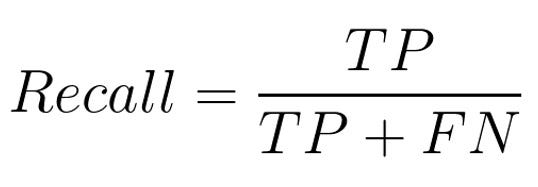

For each type, we have true positives (`mismatch_type` is 1), false negatives (`mismatch_type` is 0), and false positives (`mismatch_type` is 2), so we can calculate these values per type. The types for true and false positives are the predicted types (which is the same as the gold standard type for true positives), and the types for false negatives are the gold standard type.

The main question we're looking to answer with this analysis is why all models but GENIA perform more poorly on the GENIA-filtered PICKLE test set than on the full test set. Our hypothesis is that the other models have a more even spread of performance across all types, and that filtering down the test set only benefits GENIA since that was the metric by which we performed the filtering.

In [116]:
def calc_recall_per_type(mismatches):
    """
    Recall is the number of instances with mismatch_type == 1, divided by the sum of instances
    where the mismatch type == 1 and mismatch_type == 0, for all instances of a given gold_ent_type

    parameters:
        mismatches, df: mismatches df for a given model

    returns:
        recall, dict: recall values per type
    """
    grouped = mismatches.groupby(by=['gold_ent_type', 'mismatch_type']).count()
    recall = {}
    for gold_type in grouped.index.get_level_values('gold_ent_type'):
        try:
            tp = grouped.loc[(gold_type, 1), 'gold_ent_list']
        except KeyError:
            tp = 0
        try:
            fn = grouped.loc[(gold_type, 0), 'gold_ent_list']
        except KeyError:
            fn = 0
        rec_type = tp / (tp + fn)
        recall[gold_type] = rec_type
    
    return recall

In [117]:
rec_full_dset = {}
for model, dset in per_model.items():
    recall = calc_recall_per_type(dset)
    rec_full_dset[model] = recall
rec_filtered_dset = {}
for model, dset in per_model_filtered.items():
    recall = calc_recall_per_type(dset)
    rec_filtered_dset[model] = recall

In [118]:
all_models_filtered['gold_ent_type'].dropna().unique()

array(['dna', 'cell_type', 'protein', 'rna'], dtype=object)

In [125]:
our_models = {'scierc':0, 'genia':1, 'chemprot':2, 'seedev':3, 'pickle':4}
model_map = {
    'scierc': 'SciERC',
    'genia': 'GENIA',
    'chemprot': 'ChemProt',
    'seedev': 'SeeDev',
    'pickle': 'PICKLE'
}
full_type_map = {typ:' '.join(typ.split('_')) for typ in all_models['gold_ent_type'].dropna().unique()}
filtered_type_map = {typ:' '.join(typ.split('_')).capitalize() for typ in all_models_filtered['gold_ent_type'].dropna().unique()}
filtered_type_map['dna'] = 'DNA'
filtered_type_map['rna'] = 'RNA'

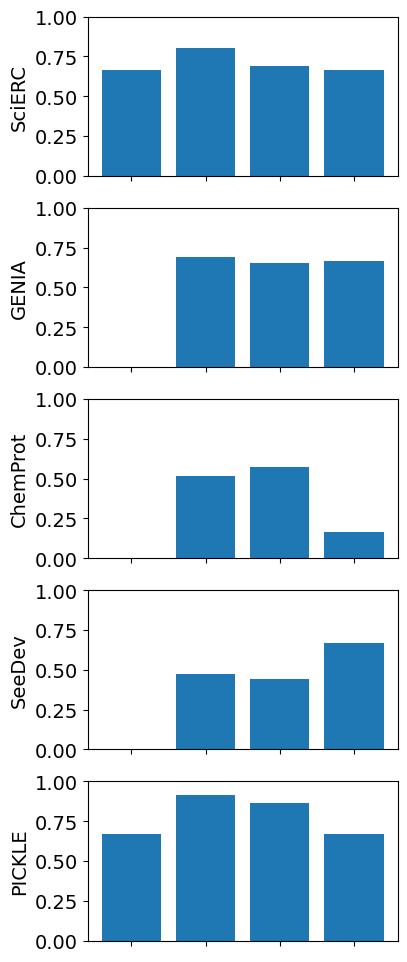

In [126]:
fig, axs = plt.subplots(5,1, figsize=(4,12), sharey=True, sharex=True)

for mod, row in our_models.items():
    axs[row].bar(range(len(rec_filtered_dset[mod])), list(rec_filtered_dset[mod].values()), tick_label=list(rec_filtered_dset[mod].keys()))
    axs[row].set_ylabel(model_map[mod])
    axs[row].set_ylim(0, 1)
semantic_xlabs = [filtered_type_map[lab] for lab in [t.get_text() for t in axs[3].get_xticklabels()]]
axs[3].set_xticklabels(semantic_xlabs)

plt.savefig('../data/straying_off_topic_data/model_performance/filtered_type_recall.png', format='png', bbox_inches='tight', dpi=600)

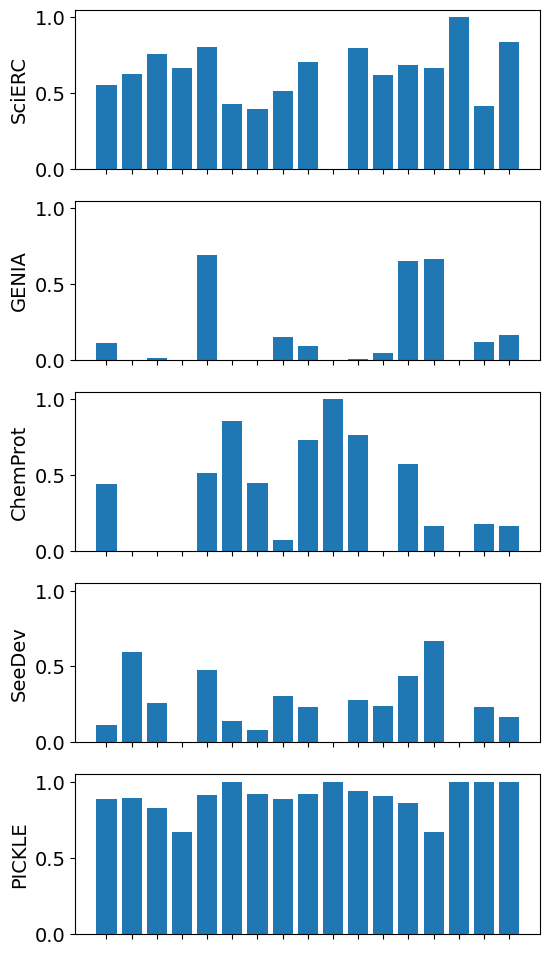

In [127]:
fig, axs = plt.subplots(5,1, figsize=(6,12), sharey=True, sharex=True)

for mod, row in our_models.items():
    axs[row].bar(range(len(rec_full_dset[mod])), list(rec_full_dset[mod].values()), tick_label=list(rec_full_dset[mod].keys()))
    axs[row].set_ylabel(model_map[mod])
semantic_xlabs = [full_type_map[lab] for lab in [t.get_text() for t in axs[3].get_xticklabels()]]
axs[3].set_xticklabels(semantic_xlabs, rotation=90)

plt.savefig('../data/straying_off_topic_data/model_performance/all_type_recall.png', format='png', bbox_inches='tight', dpi=600)

## False positive analysis
Just looking at recall per type doesn't explain why all models but GENIA perform more poorly when the dataset is filtered. The next hypothesis is that the filterind results in a greater proportion of false positives for all models but GENIA; we'll test that here by comparing the proportion of all predictions that are false positives before and after filtering.

In [153]:
prop_fp = {'Model': [], 'On original PICKLE test set': [], 'On GENIA-filtered PICKLE test set': []}
for model, dset in per_model.items():
    if model in ['seedev', 'scierc', 'genia', 'chemprot', 'pickle']:
        fp_all = len(dset[dset['mismatch_type'] == 2])
        fp_filt = len(per_model_filtered[model][per_model_filtered[model]['mismatch_type'] == 2])
        tot_preds = len(dset['pred_ent_list'].dropna().unique())
        prop_fp['Model'].append(model)
        prop_fp['On original PICKLE test set'].append(fp_all/tot_preds)
        prop_fp['On GENIA-filtered PICKLE test set'].append(fp_filt/tot_preds)
prop_fp_df = pd.DataFrame(prop_fp)
prop_fp_df['Model'] = prop_fp_df['Model'].map(model_map)  
sorter = lambda column: column.map({mod: order for order, mod in enumerate(['GENIA', 'SeeDev', 'ChemProt', 'SciERC', 'PICKLE'])})
prop_fp_df = prop_fp_df.sort_values('Model', key=sorter)
prop_fp_df = prop_fp_df.set_index('Model')
prop_fp_df

,On original PICKLE test set,On GENIA-filtered PICKLE test set
Model,,
GENIA,0.444965,0.573770
SeeDev,0.628319,0.877089
ChemProt,0.412596,0.809769
SciERC,0.520588,0.881765
PICKLE,0.116298,0.802621


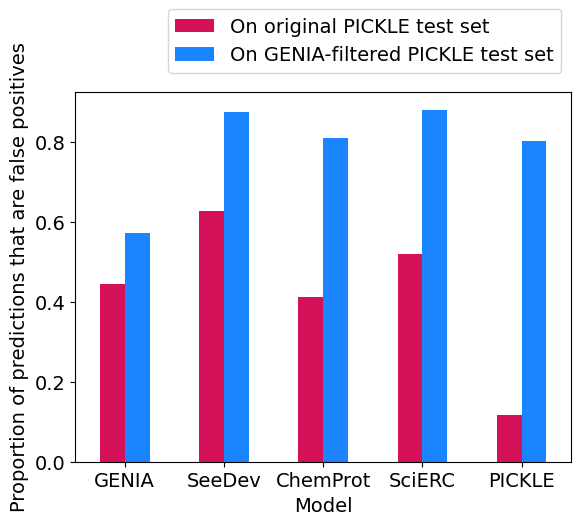

In [156]:
ax = prop_fp_df.plot.bar(color={
    'On original PICKLE test set': '#D41159',
    'On GENIA-filtered PICKLE test set': '#1A85FF'
}, ylabel='Proportion of predictions that are false positives', rot=0)
ax.legend(bbox_to_anchor=(1.0, 1.25))
plt.savefig('../data/straying_off_topic_data/model_performance/false_pos_comparison.png', format='png', )

This goes a long way to explaining what we observe, but not all the way. For example, we see that GENIA indeed has the lowest proportion of false positives on the filtered dataset, which we expect. We also see that PICKLE has the greatest change om false positive proportion, which corresponds to the large decrease in performance we see on the filtered dataset. However, we would expect the performance reduction to be proportional to the increase in false positives for all models, so we would expect that SeeDev and ChemProt should have the next-smallest increase in false positive proportion, and SciERC should have the next-largest.